<a href="https://colab.research.google.com/github/YuukiHnf/GaussianProcess/blob/main/GP_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
! pip install pyro-ppl

     |████████████████████████████████| 614kB 5.9MB/s 


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Text(0, 0.5, 'y')

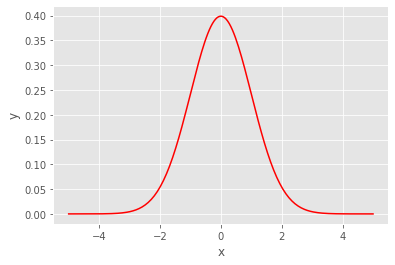

In [ ]:

N = 200
x = np.linspace(-5,5,N)
y = (1/np.sqrt(2*np.pi) * np.exp(-(1/2)*x*x))
plt.plot(x,y,'r-')
plt.xlabel('x')
plt.ylabel('y')


Text(0, 0.5, 'y')

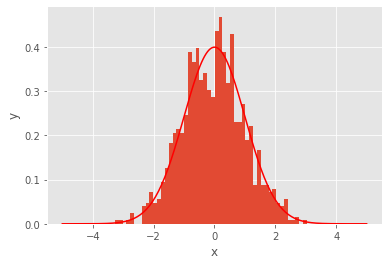

In [ ]:
N = 200
x = np.linspace(-5,5,N)
y = (1/np.sqrt(2*np.pi) * np.exp(-(1/2)*x*x))
sampling = np.random.normal(0,1,size=1000)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(sampling, bins=50, density=True)
ax.plot(x,y,'r-')
ax.set_xlabel('x')
ax.set_ylabel('y')

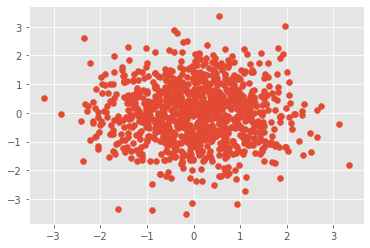

In [ ]:
N = 1000
data = np.random.normal(size=(2,N))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(data[0,:], data[1,:])


p1=[[0.4472136 ]
 [0.89442719]]
p2=[[-0.89442719]
 [ 0.4472136 ]]
P=[[ 0.4472136  -0.89442719]
 [ 0.89442719  0.4472136 ]]
D=[[2 0]
 [0 1]]
C=[[1.6 1.2]
 [1.2 3.4]]


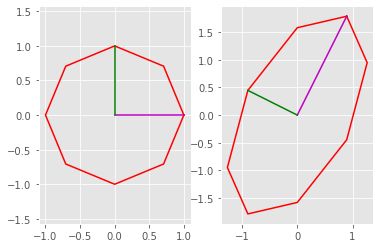

In [ ]:
# 共分散行列の構造
# 固有値と固有ベクトルから共分散行列を作ってみます。
# Σ = P Γ P' = P D D P'
# 

# (1) 互いに直交する２つの固有ベクトルを作ります。ノルムが 1.0 になるようにしておきます。
p1 = np.array([[1],[2]])/np.sqrt([2*2 + 1*1])
p2 = np.array([[-2],[1]])/np.sqrt([2*2 + 1]) 
P = np.concatenate( (p1,p2), axis=1 )
print('p1={}'.format(p1))
print('p2={}'.format(p2))
print('P={}'.format(P))

# (2) 共分散行列 C = P D D P' を作ります
# 【実習】　対角行列 D の対角成分の値を変えて実験してみましょう
sigma1 = 2
sigma2 = 1
D = np.diag( np.array([sigma1, sigma2]))
C = np.dot( np.dot(P, D*D), P.T )
print('D={}'.format(D))
print('C={}'.format(C))

# (3) 共分散行列 C に対応する線形変換行列 P D を用いて図形の線形変換をしてみます
# NN=2 のとき cx[0, i], cx[1,i] , i = 0,...,(NN*4) は原点を中心とした8角形の頂点
# 第0頂点     ( cx[0,0], cx[1,0] )      =  (1,0) と、
# 第NN頂点 　( cx[0,NN], cx[1,NN] ) =  (0,1) に着目。
# NN の値を 90 にすると正360角形（ぼぼ円）を描くことができます

NN = 2
t = np.linspace(0,1,NN*4+1)*np.pi*2
cx = np.array( [np.cos(t), np.sin(t)])

def plot_a(ax,x,n):
  ax.axis('equal')
  ax.plot( x[0,:], x[1,:], 'r-')
  ax.plot( [0,x[0,0]],[0,x[1,0]], 'm-')
  ax.plot( [0,x[0,n]],[0,x[1,n]], 'g-')

ax1 = plt.subplot(1,2,1)
plot_a(ax1, cx, NN)

ax2 = plt.subplot(1,2,2)
cx2 = np.dot( np.dot( P, D ),  cx )
plot_a(ax2, cx2, NN)

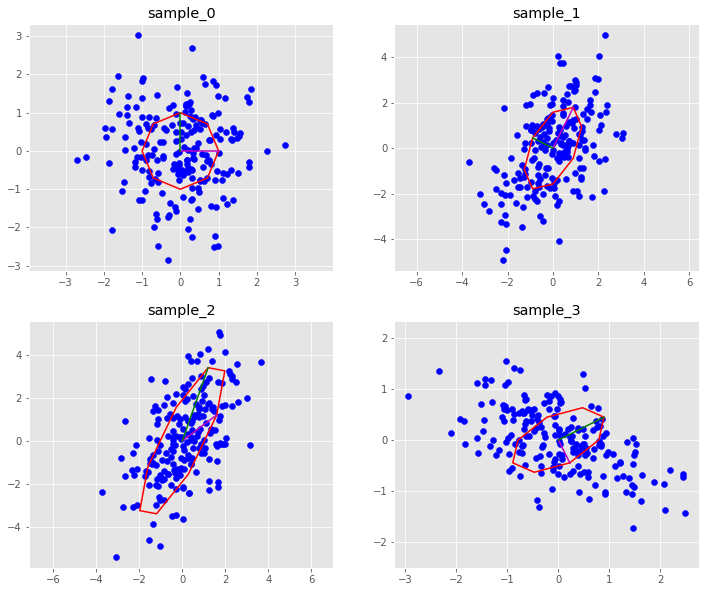

In [ ]:
# (4) 図形の線形変換を使って、正規分布の散布図を変形します

N = 200
mu = np.array([0,0])
cov = np.array([[1,0],[0,1]])
cov2 = P @ D @ D @ P.T

x_sample = np.random.multivariate_normal(mu,cov,size=N).T #(2,N)

x_sample2 = P @ D @ x_sample #(2,N)

x_sample3 = np.random.multivariate_normal(mu,cov2,size=N).T #(2,N)

x_sample4 = np.linalg.inv(D @ P.T) @ x_sample #(2,N)

NN = 2
t = np.linspace(0,1,NN*4+1)*np.pi*2
cx = np.array([ np.cos(t), np.sin(t) ]) #(2,NN*4)

cxs = np.array( [cx, P@D@cx, P@D@D@P.T@cx, np.linalg.inv(D@P)@cx])
x_samples = np.array([x_sample, x_sample2, x_sample3, x_sample4])
fig = plt.figure(figsize=(12,10))


for i in range(4):
  ax = fig.add_subplot(2,2,i+1)
  plot_a(ax,cxs[i],NN)
  ax.scatter( x_samples[i,0,:], x_samples[i,1,:], c='b')
  ax.set_title(f'sample_{i}')

# ガウス過程からサンプリングする

In [ ]:

def RBF(x, x_, theta1=1, theta2=0.01):
  return theta1 * np.exp( - theta2(np.abs(x-x_)**2) )

In [ ]:
class gaussian_processing:
  def __init__(self, kernel_func):
    self.kernel_func = kernel_func
    self.train_X = None
    self.train_Y = None
    self.K = None
    self.K_inv = None
  
  def cal_kernel_vector(self,target_x, X_vec):
    return np.array( [ self.kernel_func(target_x,x_) for x_ in X_vec] )
  
  def cal_kernel_matrix(self,X):
    return np.array( [ self.cal_kernel_vector(x_c, X).T for x_c in X ] )

  def fit(self,X,Y):
    self.train_X = X
    self.train_Y = Y - Y.mean()
    self.N = len(self.train_X)
    self.K = self.cal_kernel_matrix(self.train_X)
    self.K_inv = np.linalg.inv(self.K)

  def do_sampling(self,S=10):
    return np.random.multivariate_normal(np.zeros(N),self.K,S)

  def predict(self,test_X):
    k_test =  np.array([ self.cal_kernel_vector(x, self.train_X) for x in test_X ])
    mean = k_test @ self.K_inv @ self.train_Y
    cov = k_test @ self.K_inv @ k_test.T
    return np.random.multivariate_normal(mean,cov)

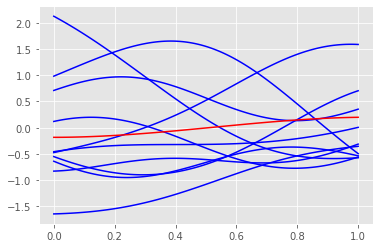

In [ ]:
def RBF(x, x_, theta1=1, theta2=2.0):
  return theta1 * np.exp( - theta2*(np.abs(x-x_)**2) )

N = 100
X = np.linspace(0,1,N)

Y = X*np.sin(X) + X*np.cos(X) - X

data_X = X
data_Y = Y - Y.mean()

GP = gaussian_processing(RBF)

GP.fit(data_X, data_Y)
plt.plot(X,GP.do_sampling(10).T,'b-')
x_ = np.linspace(0,1,100)
plt.plot(x_,  x_*np.sin(x_) + x_*np.cos(x_) - x_ - Y.mean(), 'r-')

Text(0, 0.5, 'f(x)')

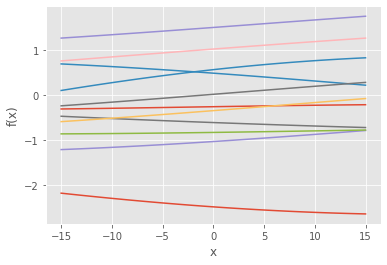

In [ ]:
X_sim = 100
x_sim = np.linspace(-15,15,X_sim)

def gaussianKernel( x1, x2 , a=0.0001):
  return np.exp( -a * (x1-x2) * (x1-x2))

def computeGram(elements, k):
  n = len(elements)
  gram = np.zeros([n,n])
  for i in range(n):
    for j in range(i+1):
      gram[i,j] = k(elements[i], elements[j])

  upTriIdxs = np.triu_indices(n)
  gram[upTriIdxs] = gram.T[upTriIdxs]
  return gram

K = computeGram( x_sim, gaussianKernel )

mu = np.zeros(X_sim)

f = np.random.multivariate_normal(mu,K)

plt.plot(x_sim, f, '-')
plt.xlabel('X')
plt.ylabel('Y')
plt.plot()

fs = np.random.multivariate_normal(mu,K,10)
plt.plot(x_sim,fs.T)
plt.xlabel('x')
plt.ylabel('f(x)')

In [ ]:
fs = np.random.multivariate_normal(mu,K,10)

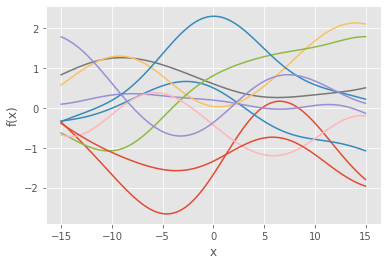

In [ ]:
plt.plot(x_sim,fs.T)
plt.xlabel('x')
plt.ylabel('f(x)')
print('')